# Setup

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import networkx as nx
import re
import csv
# plot asthetics
sns.axes_style({'font.family': ['sans-serif'],
    'font.sans-serif': ['Arial'],
    'xtick.labelsize' : 12,
    'ytick.labelsize' : 12,
    'axes.labelsize' : 12,
    });
plt.rcParams["patch.force_edgecolor"] = True # bar plot edges

In [2]:
solution_id = 'wGCP-4-0'
#base_path = 'C:\\Users\\sergio\\Dropbox\\modcell2-dev\\problems\\ecoli-gem'
base_path = '/home/sergio/Dropbox/modcell2-dev/problems/ecoli-gem'
pf_path = os.path.join(base_path,'output','report_{}.csv'.format(solution_id))
pathway_table_path = os.path.join(base_path, 'input','pathway_table.csv')
optknock_designs_path = os.path.join(os.getcwd(), 'optknock_designs.csv')
flux_table_path = os.path.join(os.getcwd(), '{}-all_pfba.csv'.format(solution_id))

# product to name
reader = csv.DictReader(open('prod_id2name.csv', 'r'))
with open('prod_id2name.csv') as f:
    prod_id2name = {d['id']: d['name'] for d in csv.DictReader(f, fieldnames=('id', 'name'))}



In [3]:
df = pd.read_csv(pf_path)
df = df[df.columns.drop(list(df.filter(regex='module|Deletion')))] # Drop module columns and deletion columns
df = df.rename(lambda x: x.replace('(objective)', ''), axis='columns') # rename columns to product ids
df.set_index('Solution index', inplace=True)
df.head()

,etoh_pdc,ppoh,btoh,ibutoh,ptoh,14btd,pyr,lac__D,ac,adpac,etylace,ppylace,ibutylace,etylbte,ppylbte,btylbte,ibutylbte,etylpte,ibutylpte,ptylpte
Solution index,,,,,,,,,,,,,,,,,,,,
1,0.095206,0.419260,0.0,0.10921,0.439310,0.426650,0.0,0.10123,0.36265,0.0,0.00000,1.127100e-01,0.0,0.00000,6.389500e-02,0.0,0.0,0.100430,1.119000e-01,4.811500e-01
2,0.249510,0.002727,0.0,0.00000,0.004020,0.003904,0.0,0.00000,0.58452,0.0,0.00000,2.809700e-14,0.0,0.00000,3.992700e-14,0.0,0.0,0.265880,5.095400e-14,3.569700e-14
3,0.249600,0.002688,0.0,0.00000,0.003961,0.003847,0.0,0.00000,0.59193,0.0,0.00000,2.809700e-14,0.0,0.00000,4.892700e-14,0.0,0.0,0.265940,5.253600e-14,2.942000e-14
4,0.251260,0.001988,0.0,0.00000,0.002930,0.002846,0.0,0.00000,0.55153,0.0,0.47629,0.000000e+00,0.0,0.34777,0.000000e+00,0.0,0.0,0.000000,0.000000e+00,2.353000e-29
5,0.251890,0.001724,0.0,0.00000,0.002541,0.002467,0.0,0.00000,0.54669,0.0,0.00000,1.518800e-29,0.0,0.00000,0.000000e+00,0.0,0.0,0.002471,0.000000e+00,5.125300e-32


# Pareto front

In [4]:
pt = pd.read_csv(pathway_table_path)
lut = dict(zip(pt.product_tags.unique(), "rbg"))
id_to_col = dict(zip(pt.id, pt.product_tags.map(lut)))
row_colors = [id_to_col[id] for id in list(df.columns)]
lut

{'alcohol': 'r', 'ester': 'g', 'organic acid': 'b'}

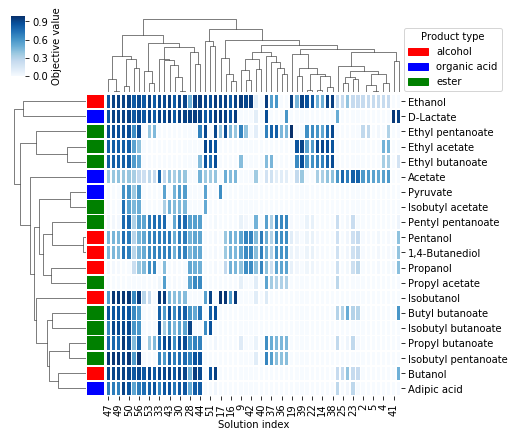

In [5]:
df_names = df.rename(prod_id2name, axis='columns')
g = sns.clustermap(df_names.transpose(),row_colors=row_colors,
                   cmap="Blues",linewidths=.75, figsize=(7, 7),cbar_kws={"label": "Objective value", "ticks":[0,0.3,0.6,0.9]})
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0);

# product class legend
legend_TN = [mpatches.Patch(color=c, label=l) for l, c in lut.items()]
l2=g.ax_heatmap.legend(loc=(0,20),bbox_to_anchor=(1.01,1.01),handles=legend_TN,frameon=True)
l2.set_title(title='Product type',prop={'size':10})

# Use full name 
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels())

# save
g.savefig('pf-{}.svg'.format(solution_id), format='svg')
#g.savefig('pf-{}.pdf'.format(solution_id))

# Compatibility

In [7]:
cpf = df_names >= 0.6
comp = cpf.sum(axis=1)

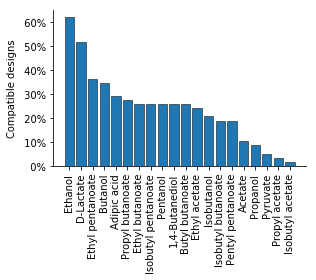

In [11]:
compc = pd.DataFrame(cpf.sum(axis=0))
compc['norm'] = compc[0].map(lambda x: x/cpf.shape[0])
compc = compc.sort_values(0, ascending=False)
#sns.jointplot(x="x", y="y", data=df);
fig = plt.figure(figsize=(4.5,4))
plt.bar(x=range(len(compc.index)),height=compc['norm'], tick_label=list(compc.index),linewidth=0.5)
ax = plt.gca()
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
plt.xticks(rotation=90);
plt.subplots_adjust(bottom=0.20)
plt.ylabel('Compatible designs');
plt.tight_layout()
sns.despine()
#ax.set_xticklabels(ax.get_xticklabels(), rotation = 50, ha="right")
plt.savefig('product-compat-{}.svg'.format(solution_id))
compc.to_csv('raw_compat_designs.csv')

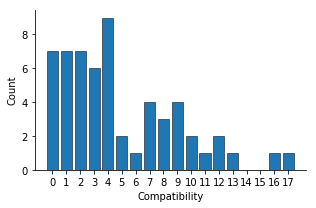

In [13]:
#  simple distribution
fig = plt.figure(figsize=(4.5,3))
data = comp
d = np.diff(np.unique(data)).min()
left_of_first_bin = data.min() - float(d)/2
right_of_last_bin = data.max() + float(d)/2
plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d), rwidth=0.8,linewidth=0.5)
plt.xticks(range(0,data.max()+1));
plt.xlabel('Compatibility')
plt.ylabel('Count');
plt.tight_layout()
sns.despine()
plt.savefig('compat-distrib-{}.svg'.format(solution_id))
comp.to_csv('raw_compatibility.csv')

In [14]:
# best value
comp[comp == max(comp)]

Solution index
48    17
dtype: int64

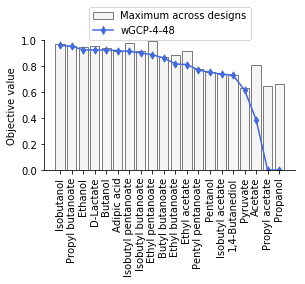

In [182]:
import matplotlib.patches as mpatches
sdf =pd.DataFrame(df_names.loc[48,:].sort_values(ascending=False))
maxdf = pd.DataFrame(df_names.max(0), columns=['max'])
fdf =sdf.join(maxdf)

#Basic plots
fig = plt.figure(figsize=(4.5,4))
ax = fig.gca()
xticks = np.arange(0,len(sdf))
ax.bar(x=xticks,height=fdf['max'],color='whitesmoke', zorder=1, linewidth=0.5)
ax.scatter(x=xticks, y=fdf[48],zorder=2, color='royalblue', marker='d',s=25)
ax.plot(fdf[48].values,color='royalblue')

# Axis labels
ax.set_ylim((0,1))
ax.set_xticks(xticks)
ax.set_xticklabels(fdf.index)
plt.xticks(rotation=90);
ax.set_ylabel('Objective value')

#Legend

bar_patch = mpatches.Patch(label='Maximum across designs', facecolor='whitesmoke', edgecolor='k',linewidth=0.5)
blue_line = mlines.Line2D([], [], color='royalblue', marker='d',
                          markersize=5, label='wGCP-4-48')

ax.legend(handles=[bar_patch, blue_line], loc='upper center', bbox_to_anchor=(0.5, 1.3))

# Final adjustments
plt.subplots_adjust(bottom=0.40, top=0.85)
sns.despine()
plt.savefig('tradeoff-{}.pdf'.format(solution_id))

In [ ]:
g.savefig('prod_net_correlation.pdf')